In [1]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

In [2]:
# install Python packages
sc.install_pypi_package("pandas==1.0.5", "https://pypi.org/simple")
sc.install_pypi_package("scipy==1.4.1", "https://pypi.org/simple")
sc.install_pypi_package("matplotlib==3.2.1", "https://pypi.org/simple")

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3,application_1716567260010_0005,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/af/f3/683bf2547a3eaeec15b39cef86f61e921b3b187f250fcd2b5c5fb4386369/pandas-1.0.5-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/ec/57/56b9bcc3c9c6a792fcbaf139543cee77261f3651ca9da0c93f5c1221264b/python_dateutil-2.9.0.post0-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/dd/82/c1fe128f3526b128cfd185580ba40d01371c5d299fcf7f77968e22dfcc2e/scipy-1.4.1-cp37-cp37m-manylinux1_x86_64.whl

  Using cached https://files.pythonhosted.org/packages/b2/c2/71fcf957710f3ba1f09088b35776a799ba7dd95f7c2b195ec800933b276b/matplotlib-3.2.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/9d/ea/6d76df31432a0e6fdf81681a895f009a4bb47b3c39036db3e1b528191d52/pyparsing-3.1.2-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5c/f9/695d6bedebd747e5eb0fe8fad57b72fdf25411273a39791cde838d5a8f51/cycler-0.11.0-py3-none-any.whl
  Using cach

In [3]:
from pyspark.sql.functions import udf, col, split, lower, regexp_replace, trim, when
from pyspark.sql.types import StringType, FloatType, IntegerType
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from pyspark.ml.linalg import Vectors

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# Read JSON file from S3
path = 's3://macs30213-thomas/arxiv.json'
data = spark.read.json(path)
df.describe().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- abstract: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- authors_parsed: array (nullable = true)
 |    |-- element: array (containsNull = true)
 |    |    |-- element: string (containsNull = true)
 |-- categories: string (nullable = true)
 |-- comments: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- id: string (nullable = true)
 |-- journal-ref: string (nullable = true)
 |-- license: string (nullable = true)
 |-- report-no: string (nullable = true)
 |-- submitter: string (nullable = true)
 |-- title: string (nullable = true)
 |-- update_date: string (nullable = true)
 |-- versions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- created: string (nullable = true)
 |    |    |-- version: string (nullable = true)

In [5]:
arxiv_fields = {'astro-ph': 'Astronomy',
                'astro-ph.CO': 'Astronomy',
                'astro-ph.EP': 'Astronomy',
                'astro-ph.GA': 'Astronomy',
                'astro-ph.HE': 'Astronomy',
                'astro-ph.IM': 'Astronomy',
                'astro-ph.SR': 'Astronomy',
                'cond-mat.dis-nn': 'Physics',
                'cond-mat.mes-hall': 'Physics',
                'cond-mat.mtrl-sci': 'Physics',
                'cond-mat.other': 'Physics',
                'cond-mat.quant-gas': 'Physics',
                'cond-mat.soft': 'Physics',
                'cond-mat.stat-mech': 'Physics',
                'cond-mat.str-el': 'Physics',
                'cond-mat.supr-con': 'Physics',
                'cond-mat': 'Physics',
                'cs.AI': 'Computer Science',
                'cs.AR': 'Computer Science',
                'cs.CC': 'Computer Science',
                'cs.CE': 'Computer Science',
                'cs.CG': 'Computer Science',
                'cs.CL': 'Computer Science',
                'cs.CR': 'Computer Science',
                'cs.CV': 'Computer Science',
                'cs.CY': 'Computer Science',
                'cs.DB': 'Computer Science',
                'cs.DC': 'Computer Science',
                'cs.DL': 'Computer Science',
                'cs.DM': 'Computer Science',
                'cs.DS': 'Computer Science',
                'cs.ET': 'Computer Science',
                'cs.FL': 'Computer Science',
                'cs.GL': 'Computer Science',
                'cs.GR': 'Computer Science',
                'cs.GT': 'Computer Science',
                'cs.HC': 'Computer Science',
                'cs.IR': 'Computer Science',
                'cs.IT': 'Computer Science',
                'cs.LG': 'Computer Science',
                'cs.LO': 'Computer Science',
                'cs.MA': 'Computer Science',
                'cs.MM': 'Computer Science',
                'cs.MS': 'Computer Science',
                'cs.NA': 'Computer Science',
                'cs.NE': 'Computer Science',
                'cs.NI': 'Computer Science',
                'cs.OH': 'Computer Science',
                'cs.OS': 'Computer Science',
                'cs.PF': 'Computer Science',
                'cs.PL': 'Computer Science',
                'cs.RO': 'Computer Science',
                'cs.SC': 'Computer Science',
                'cs.SD': 'Computer Science',
                'cs.SE': 'Computer Science',
                'cs.SI': 'Computer Science',
                'cs.SY': 'Computer Science',
                'econ.EM': 'Math',
                'eess.AS': 'Physics',
                'eess.IV': 'Physics',
                'eess.SP': 'Physics',
                'gr-qc': 'Astronomy',
                'hep-ex': 'Physics',
                'hep-lat': 'Physics',
                'hep-ph': 'Physics',
                'hep-th': 'Physics',
                'math.AC': 'Math',
                'math.AG': 'Math',
                'math.AP': 'Math',
                'math.AT': 'Math',
                'math.CA': 'Math',
                'math.CO': 'Math',
                'math.CT': 'Math',
                'math.CV': 'Math',
                'math.DG': 'Math',
                'math.DS': 'Math',
                'math.FA': 'Math',
                'math.GM': 'Math',
                'math.GN': 'Math',
                'math.GR': 'Math',
                'math.GT': 'Math',
                'math.HO': 'Math',
                'math.IT': 'Math',
                'math.KT': 'Math',
                'math.LO': 'Math',
                'math.MG': 'Math',
                'math.MP': 'Math',
                'math.NA': 'Math',
                'math.NT': 'Math',
                'math.OA': 'Math',
                'math.OC': 'Math',
                'math.PR': 'Math',
                'math.QA': 'Math',
                'math.RA': 'Math',
                'math.RT': 'Math',
                'math.SG': 'Math',
                'math.SP': 'Math',
                'math.ST': 'Math',
                'math-ph': 'Math',
                'nlin.AO': 'Physics',
                'nlin.CD': 'Physics',
                'nlin.CG': 'Physics',
                'nlin.PS': 'Physics',
                'nlin.SI': 'Physics',
                'nucl-ex': 'Physics',
                'nucl-th': 'Physics',
                'physics.acc-ph': 'Physics',
                'physics.ao-ph': 'Physics',
                'physics.app-ph': 'Physics',
                'physics.atm-clus': 'Physics',
                'physics.atom-ph': 'Physics',
                'physics.bio-ph': 'Physics',
                'physics.chem-ph': 'Physics',
                'physics.class-ph': 'Physics',
                'physics.comp-ph': 'Physics',
                'physics.data-an': 'Physics',
                'physics.ed-ph': 'Physics',
                'physics.flu-dyn': 'Physics',
                'physics.gen-ph': 'Physics',
                'physics.geo-ph': 'Physics',
                'physics.hist-ph': 'Physics',
                'physics.ins-det': 'Physics',
                'physics.med-ph': 'Physics',
                'physics.optics': 'Physics',
                'physics.plasm-ph':'Physics',
                'physics.pop-ph': 'Physics',
                'physics.soc-ph': 'Physics',
                'physics.space-ph': 'Physics',
                'q-bio.BM': 'Physics',
                'q-bio.CB': 'Physics',
                'q-bio.GN': 'Physics',
                'q-bio.MN': 'Physics',
                'q-bio.NC': 'Physics',
                'q-bio.OT': 'Physics',
                'q-bio.PE': 'Physics',
                'q-bio.QM': 'Physics',
                'q-bio.SC': 'Physics',
                'q-bio.TO': 'Physics',
                'q-fin.CP': 'Math',
                'q-fin.EC': 'Math',
                'q-fin.GN': 'Math',
                'q-fin.MF': 'Math',
                'q-fin.PM': 'Math',
                'q-fin.PR': 'Math',
                'q-fin.RM': 'Math',
                'q-fin.ST': 'Math',
                'q-fin.TR': 'Math',
                'quant-ph': 'Physics',
                'stat.AP': 'Math',
                'stat.CO': 'Math',
                'stat.ME': 'Math',
                'stat.ML': 'Math',
                'stat.OT': 'Math',
                'stat.TH': 'Math',
                'supr-con': 'Physics',
                'econ.GN': 'Math',
                'mtrl-th': 'Physics',
                'dg-ga': 'Math',
                'comp-gas': 'Physics',
                'cmp-lg': 'Computer Science',
                'solv-int': 'Physics',
                'acc-phys': 'Physics',
                'patt-sol': 'Physics',
                'funct-an': 'Math',
                'econ.TH': 'Math',
                'ao-sci': 'Physics',
                'q-alg': 'Math',
                'eess.SY': 'Physics',
                'chem-ph': 'Physics',
                'alg-geom': 'Math',
                'atom-ph': 'Physics',
                'plasm-ph': 'Physics',
                'chao-dyn': 'Physics',
                'bayes-an': 'Math',
                'adap-org': 'Physics'
                }

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
# Extract abstracts and categories
df = data.select('abstract', 'categories')

# Extract the first category
df = df.withColumn("categories", split(col("categories"), " ").getItem(0))

# Create a broadcast variable
broadcast_dict = spark.sparkContext.broadcast(arxiv_fields)

# Map categories to fields
def map_category(categories):
    if categories:
        return broadcast_dict.value.get(categories, "Unknown")
map_category_udf = udf(map_category, StringType())

# Apply UDF
df = df.withColumn("field", map_category_udf(col("categories")))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
# Preprocess text
df = df.withColumn('abstract', lower(col('abstract'))) # convert to lowercase
df = df.withColumn('abstract', regexp_replace(col('abstract'), '[^a-zA-Z\s]', '')) # remove punctuation 
df = df.withColumn('abstract', trim(col('abstract'))) # remove trailing spaces

# Tokenize text
tokenizer = RegexTokenizer(inputCol="abstract", outputCol="words", pattern="\\W")

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="tokens")

# Convert text to vectors
vectorizer = CountVectorizer(inputCol="tokens", outputCol="features")

# Convert labels to indices
string_indexer = StringIndexer(inputCol="field", outputCol="label")

# Create a pipeline
pipeline = Pipeline(stages=[tokenizer, remover, vectorizer, string_indexer])

# Fit and transform data
model = pipeline.fit(df)
dataset = model.transform(df)

# Display processed data
dataset = dataset.select('tokens', 'features', 'field', 'label')
dataset.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------+-----+
|              tokens|            features|    field|label|
+--------------------+--------------------+---------+-----+
|[fully, different...|(262144,[1,11,20,...|  Physics|  0.0|
|[describe, new, a...|(262144,[2,5,14,1...|     Math|  1.0|
|[evolution, earth...|(262144,[0,1,5,12...|  Physics|  0.0|
|[show, determinan...|(262144,[3,222,24...|     Math|  1.0|
|[paper, show, com...|(262144,[3,4,8,69...|     Math|  1.0|
|[study, twopartic...|(262144,[2,5,6,9,...|  Physics|  0.0|
|[rather, nonstand...|(262144,[0,3,6,8,...|Astronomy|  3.0|
|[general, formula...|(262144,[2,7,18,3...|  Physics|  0.0|
|[discuss, results...|(262144,[1,2,5,6,...|Astronomy|  3.0|
|[partial, cubes, ...|(262144,[2,8,14,2...|     Math|  1.0|
|[paper, present, ...|(262144,[4,8,13,1...|     Math|  1.0|
|[recently, bruini...|(262144,[4,5,8,9,...|     Math|  1.0|
|[serre, obtained,...|(262144,[4,5,8,15...|     Math|  1.0|
|[article, discuss...|(262144,[15,23,12.

In [8]:
# Find correspoding indices and fields
labels = model.stages[3].labels
for i, label in enumerate(labels):
    print(f"Index {i} corresponds to '{label}'")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Index 0 corresponds to 'Physics'
Index 1 corresponds to 'Math'
Index 2 corresponds to 'Computer Science'
Index 3 corresponds to 'Astronomy'

In [9]:
# Initialize a Logisic Regression classifier
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Split data
train, test = dataset.randomSplit([0.7, 0.3])

# Train the model
lr_model = lr.fit(train)

# Test the model
predictions = lr_model.transform(test)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
# Initialize a multiclass evaluator
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="label", metricName="accuracy")

# Evaluate test accuracy
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy:", accuracy)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test Accuracy: 0.8638154751359564

In [11]:
# Initialize a binaryclass evaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="probability", labelCol="label", metricName="areaUnderROC")

fields = ['Computer Science', 'Physics', 'Math', 'Astronomy']
roc_auc = []

# Calculate ROC for each field
for i, field in enumerate(fields):
    binary_predictions = predictions.withColumn("binary_label", when(col("label") == i, 1).otherwise(0))
    auc = evaluator.evaluate(binary_predictions, {evaluator.labelCol: "binary_label"})
    roc_auc.append((i, auc))
    print(f"{field} AUC: {auc}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Computer Science AUC: 0.34670427235911
Physics AUC: 0.9603017074103793
Math AUC: 0.43717168248343435
Astronomy AUC: 0.2068281789731948

In [12]:
def compute_roc(predictions, class_index, total_classes):
    # Filter probabilities for one class
    get_class_probability = udf(lambda v: float(v[class_index]), FloatType())
    predictions_class = predictions.withColumn("probability", get_class_probability(col("probability")))

    # Employ binary labels
    binary_label = udf(lambda l: 1 if l == class_index else 0, IntegerType())
    predictions_class = predictions_class.withColumn("binary_label", binary_label(col("label")))

    # Sort by probability
    predictions_class = predictions_class.orderBy(col("probability").desc())

    # Count positive and negative labels
    num_positives = predictions_class.where(col("binary_label") == 1).count()
    num_negatives = predictions_class.where(col("binary_label") == 0).count()
    
    # Initialize counters
    tp = 0
    fp = 0
    prev_prob = -1
    fpr = []
    tpr = []
    
    # Collect data
    collected_data = predictions_class.select("probability", "binary_label").collect()

    for row in collected_data:
        prob, label = row
        if prob != prev_prob:
            fpr.append(fp / num_negatives if num_negatives != 0 else 0)
            tpr.append(tp / num_positives if num_positives != 0 else 0)
            prev_prob = prob
        if label == 1:
            tp += 1
        else:
            fp += 1

    fpr.append(fp / num_negatives if num_negatives != 0 else 0)
    tpr.append(tp / num_positives if num_positives != 0 else 0)

    return fpr, tpr

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
# Calculate ROC data
roc_data = {}

for i, field in enumerate(fields):
    fpr, tpr = compute_roc(predictions, i, 4)
    roc_data[field] = (fpr, tpr)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

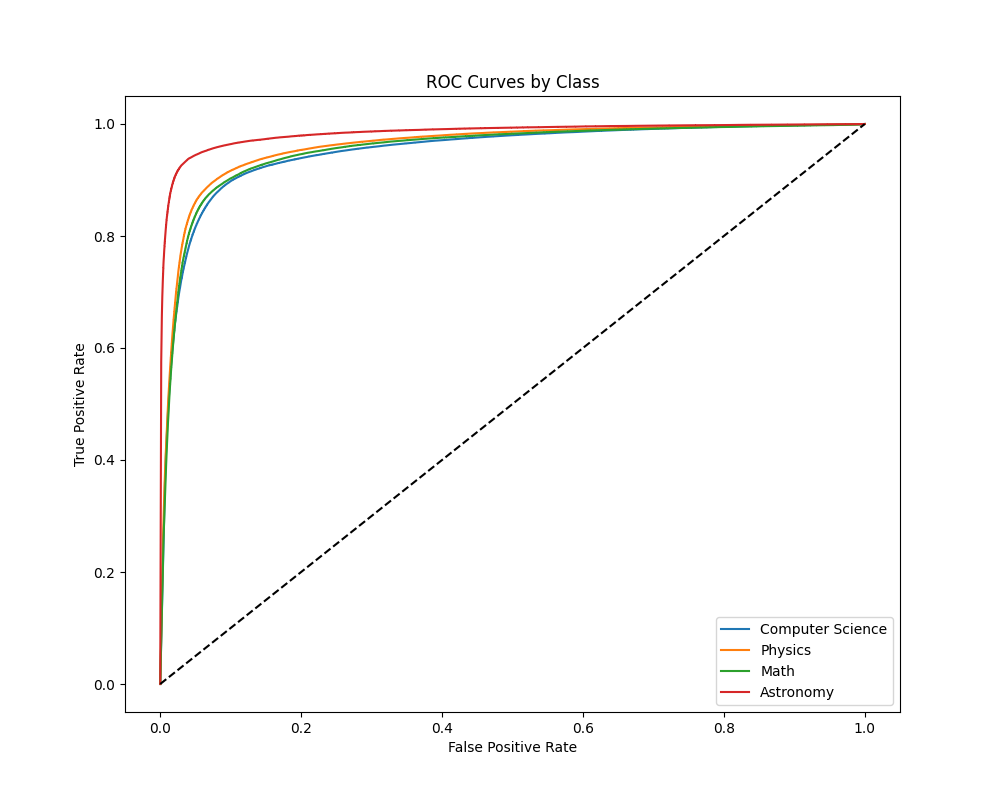

In [14]:
# Plot
plt.close()
plt.figure(figsize=(10, 8))

for class_index, (fpr, tpr) in roc_data.items():
    plt.plot(fpr, tpr, label=f'{class_index}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Class')
plt.legend(loc="lower right")
%matplot plt